# [GoingDeeper] NLP_01 SentencePiece

In [1]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## 데이터 불러오기 및 전처리

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f0814657e50>)

In [3]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [4]:
origin_len = len(naver_df)
naver_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [5]:
naver_df = naver_df.dropna(how='any')
#print(naver_df.isnull().sum)
print('결측치 제거 후 데이터 개수 :', len(naver_df))  

결측치 제거 후 데이터 개수 : 199992


In [6]:
naver_review = naver_df['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 35


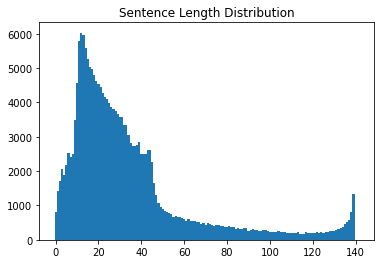

In [7]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

sentence_length = np.zeros((max_len), dtype=int)

for sen in naver_review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [8]:
def check_sentence_with_length(naver_review, length):
    count = 0
    
    for sen in naver_review:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(naver_review, 1)

굿
핡
굿
휴
굿
시
ㅋ
ㅇ
굿
‥
O
굿
굿
굿
갑
ㅎ
굿
.
올
굿
헷
g
굿
♥
.
짱
짱
ㅆ
.
굿
짱
굿
.
굿
굿
굿
.
굿
짱
굳
굿
잼
굿
짱
굿
굿
ㅎ
굿
굿
굿
ㅁ
굳
굿
굿
?
ㅎ
굿
굿
.
짱
ㅇ
ㅋ
애
굿
ㅋ
굿
?
짱
.
흠
굿
ㅋ
!
굿
찜
b
굿
굳
짱
짱
짱
짱
굿
굿
짱
굿
,
♥
굳
.
굿
굳
ㅎ
굿
굿
.
굿
굳
굿
굿
굿


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


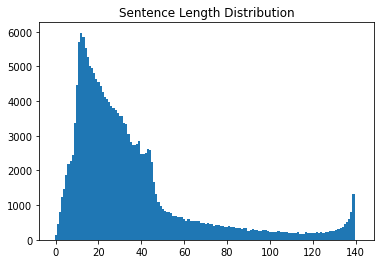

In [9]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(naver_review))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

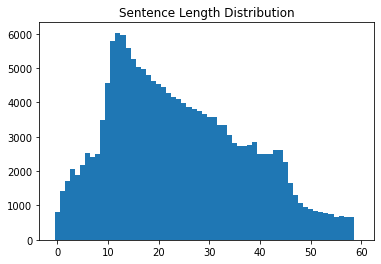

In [10]:
max_len = 60
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

filtered_corpus = [] 
filtered_label = []  
for s, label in zip(naver_df['document'], naver_df['label']):    
    if (len(s) < max_len):     
        filtered_corpus.append(s)  
        filtered_label.append(label) 
        
# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [11]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

## SentencePiece 

In [49]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
vocab_size = 16000
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_16k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size*2)    
)
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')


#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*
!ls -l korean_spm_16k*

-rw-r--r-- 1 root root 375162 Aug 16 08:38 korean_spm.model
-rw-r--r-- 1 root root 144497 Aug 16 08:38 korean_spm.vocab
ls: cannot access 'korean_spm_16k*': No such file or directory


In [13]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1661, 9, 467, 16, 1396, 9, 161, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Tokenizer 함수 작성

In [14]:
#훈련시킨 SentencePiece를 활용해 tokenizer역할을 하는 함수를 정의
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [15]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

## 모델 학습

In [40]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(filtered_label)
X_train, X_test, y_train, y_test = train_test_split(tensor, filtered_label, test_size=0.2)

In [41]:
tensor.shape

(171835, 50)

In [42]:
filtered_label.shape

(171835,)

In [43]:
# Define the model architecture
vocab_size = 8000  
word_vector_dim = 32  

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
4296/4296 [==============================] - 15s 3ms/step - loss: 0.4186 - accuracy: 0.8114 - val_loss: 0.3558 - val_accuracy: 0.8454
Epoch 2/10
4296/4296 [==============================] - 14s 3ms/step - loss: 0.3346 - accuracy: 0.8567 - val_loss: 0.3570 - val_accuracy: 0.8421
Epoch 3/10
4296/4296 [==============================] - 14s 3ms/step - loss: 0.3226 - accuracy: 0.8620 - val_loss: 0.3422 - val_accuracy: 0.8488
Epoch 4/10
4296/4296 [==============================] - 15s 3ms/step - loss: 0.3133 - accuracy: 0.8650 - val_loss: 0.3427 - val_accuracy: 0.8488
Epoch 5/10
4296/4296 [==============================] - 14s 3ms/step - loss: 0.3036 - accuracy: 0.8680 - val_loss: 0.3478 - val_accuracy: 0.8480
Epoch 6/10
4296/4296 [==============================] - 14s 3ms/step - loss: 0.2949 - accuracy: 0.8704 - val_loss: 0.3491 - val_accuracy: 0.8469
Epoch 7/10
4296/4296 [==============================] - 15s 3ms/step - loss: 0.2868 - accuracy: 0.8747 - val_loss: 0.3554 - val_ac

In [44]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1074/1074 - 1s - loss: 0.3775 - accuracy: 0.8445
[0.377459317445755, 0.8444728851318359]


## KoNLPy의 Mecab 모델

In [27]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def data_load(num_words=10000):
    
    x_train, x_val, y_train, y_val = train_test_split(naver_df['document'], naver_df['label'], test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    
    def tokenize(data):
        result = []
        for sentence in data:
            temp = tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in stopwords] 
            result.append(temp)
        return result
   
    X_train = tokenize(x_train)
    X_test = tokenize(x_test)
    X_val = tokenize(x_val)
                                                         
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_val = list(map(wordlist_to_indexlist, X_val))
                                                                                                             
    return X_train, y_train, X_test, y_test, X_val, y_val, word_to_index

In [28]:
x_train, y_train, x_test, y_test, x_val, y_val, word_to_index = data_load()

In [29]:
index_to_word = { index: word for word, index in word_to_index.items() }

In [30]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=70)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=70)

x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=70)

x_train.shape, x_test.shape, x_val.shape

((127994, 70), (31999, 70), (39999, 70))

In [31]:
y_train.shape, y_test.shape, y_val.shape

((127994,), (31999,), (39999,))

In [32]:
vocab_size = len(word_to_index)
word_vector_dim = 128

In [33]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [34]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

epochs=20
batch_size=64

history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(x_val, y_val), callbacks=es, verbose=1)

Epoch 1/20
2000/2000 [==============================] - 31s 6ms/step - loss: 0.3666 - accuracy: 0.8365 - val_loss: 0.3209 - val_accuracy: 0.8602
Epoch 2/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2823 - accuracy: 0.8790 - val_loss: 0.3151 - val_accuracy: 0.8665
Epoch 3/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2427 - accuracy: 0.8978 - val_loss: 0.3323 - val_accuracy: 0.8666
Epoch 4/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.2084 - accuracy: 0.9140 - val_loss: 0.3466 - val_accuracy: 0.8664
Epoch 5/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1758 - accuracy: 0.9291 - val_loss: 0.3771 - val_accuracy: 0.8621
Epoch 6/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1458 - accuracy: 0.9423 - val_loss: 0.4234 - val_accuracy: 0.8515
Epoch 00006: early stopping


In [35]:
result_mecab = model.evaluate(x_test, y_test, verbose=1)

1000/1000 [==============================] - 3s 3ms/step - loss: 0.4172 - accuracy: 0.8510


### 결과   
sp는 84%, KoNLPy는 85%의 accuracy가 나오는 것으로 보아, 성능에 큰 차이는 없는 것 같다.